Now let's test how would the things work if we consider a 2-D gaussian and use a NF architecture based on slope-constrained neural splines!

In [1507]:
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [1508]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.init as init

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained

import os
import json
from tqdm import tqdm

import torch.optim as optim
from torch.nn.utils import clip_grad_norm_



In [1509]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [1510]:
def plot_2d_scatter_with_marginals(data, height=4.5):
    """
    Plot a 2D scatter plot with marginal histograms for a 2D dataset.

    Args:
    - data: 2D numpy array of shape (n_samples, 2)
    - height: Height of the plot in inches (default: 6)

    Returns:
    None (displays the plot)
    """
    # Create a joint plot with scatter and marginal histograms
    g = sns.jointplot(
        x=data[:, 0],
        y=data[:, 1],
        kind="scatter",
        marginal_kws=dict(bins=30, fill=True),
        height=height
    )

    # Add grid to the scatter plot axes
    g.ax_joint.grid(True)

    # Optionally, add grid to the marginal histograms
    g.ax_marg_x.grid(True)
    g.ax_marg_y.grid(True)

    # Display the plot
    plt.show()


In [1511]:
def plot_coefficients_evolution(num_coeffs,coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs= List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    
    '''
    plt.figure(figsize=(10, 6))

    for i in range(0,num_coeffs):
        plt.plot(coeffs[:,i],"-o",label=f"coeff[{i}]")
        plt.plot(slope_constr_coeffs[:,i],":o",label=f"slope constr coeff[{i}]")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    if log_scale:
        plt.yscale("log")
    plt.xlabel("training epochs")
    plt.ylabel("coefficient values")
    plt.grid(1)
    plt.title("Evolution of coefficients with training of a spline")
    plt.tight_layout()


In [1512]:
# Function to generate data from a 2D Gaussian distribution
def generate_2d_gaussian_data(mean, cov_matrix, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 2D Gaussian distribution.

    Parameters:
    - mean: Mean vector of the 2D Gaussian distribution (list or array of length 2)
    - cov_matrix: Covariance matrix of the 2D Gaussian distribution (2x2 matrix)
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate 2D Gaussian data
    data = np.random.multivariate_normal(mean, cov_matrix, total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = [0,0]  # Mean of the Gaussian (2D vector)
cov_matrix = [[1, 0], [0, 1]]  # Covariance matrix (2x2)
total_samples = 10000

# Generate the data
train_data, val_data, test_data = generate_2d_gaussian_data(mean, cov_matrix, total_samples)

# Convert to DataLoaders
batch_size = 8
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# generate the data and see how it works

Training set size: 7000
Validation set size: 1500
Test set size: 1500


In [1513]:
def plot_z_and_2d_normal(z, num_samples=1000, 
                    mean=(0, 0), cov=[[1, 0], [0, 1]], 
                    figsize=(8, 6)):
    """
    Plots a 2D scatter of z and data sampled from a 2D normal distribution.

    Args:
    - z (numpy.ndarray): Array of shape (N, 2) representing 2D points to plot.
    - num_samples (int): Number of points to sample from the 2D normal distribution.
    - mean (tuple): Mean of the 2D normal distribution.
    - cov (list[list]]): Covariance matrix of the 2D normal distribution.
    - figsize (tuple): Size of the figure.

    Returns:
    None
    """
    # Sample from a 2D normal distribution
    normal_samples = np.random.multivariate_normal(mean, cov, num_samples)

    # Create the scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(normal_samples[:, 0], normal_samples[:, 1], color='blue', alpha=0.5, label="2D Normal Samples")
    plt.scatter(z[:, 0], z[:, 1], color='red', alpha=0.8, label="z Points")
    plt.title("Scatter Plot of z and 2D Normal Distribution Samples")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.grid(True)
    plt.show()





In [1514]:
def get_weight_determinants(model):
    """
    Calculate the determinants of the weight matrices of each linear layer in the model.

    Args:
    - model (nn.Module): The model containing the layers.

    Returns:
    - determinants (torch.tensor): A list of determinants of the weight matrices for each linear layer.
    """
    determinants = []

    # Iterate over all layers in the model
    for layer in model.modules():
        if isinstance(layer, nn.Linear):  # Check if it's a Linear layer
            # Calculate the determinant of the weight matrix if it's square
            if layer.weight.shape[0] == layer.weight.shape[1]:
                det = torch.linalg.det(layer.weight)
                determinants.append(det.item())  # Convert tensor to scalar and add to list
            else:
                print(f"Layer with weight matrix of shape {layer.weight.shape} is not square. Skipping determinant calculation.")
                determinants.append(None)
    return torch.tensor(determinants)

def prod_model_activations_jacobians(model):
    """
    Process the model's activations by:
    1. Performing column-wise multiplication for each activation layer.
    2. Pointwise multiplying the reduced vectors to obtain a final vector.

    Args:
        model: The model containing activations with grad_x_temp.

    Returns:
        A tensor representing the final pointwise multiplied vector.
    """
    reduced_activations = []
    
    # Iterate over all activations
    for i in range(len(model.activations)):
        # Get the grad_x_temp tensor for the current activation layer
        grad_x_temp = model.activations[i].grad_x_temp
        # print("grad_x_temp is:"); print(grad_x_temp)
        # Column-wise multiplication (reduce along rows)
        reduced = torch.prod(grad_x_temp, dim=0, keepdim=True)
        # print("reduced is:"); print(reduced)
        reduced_activations.append(reduced)
    
    # Perform pointwise multiplication across all reduced activations
    result_vector = reduced_activations[0]
    for reduced in reduced_activations[1:]:
        result_vector = result_vector * reduced  # Pointwise multiplication
    # print("resultant vector:"); print(result_vector)
    return result_vector


In [1515]:
# DEFINING OUR LOSS
def nll_loss(z, det_jacob_act, linear_layers_det=None):
    '''
    z : tensor z in latent space
    det_jacob_act : tensor of the form (determinants from activations layers)
    linear_layers_det : tensor of the form (for all "c" linear layers)
        - This is optional; it is only needed for models with linear layers.

    Returns:
    - loss: computed loss value
    '''
    # Latent space penalty (same for both models)
    loss_1 = 0.5 * torch.sum(z**2)

    # Jacobian determinant penalty from activation layers
    loss_2a = torch.sum(torch.log(torch.abs(det_jacob_act) + 1e-10))

    # If linear_layers_det is provided, use it in the loss calculation
    loss_2b = 0
    if linear_layers_det is not None:
        loss_2b = torch.sum(torch.log(torch.abs(linear_layers_det) + 1e-10))

    # Dataset length (number of examples)
    dataset_length = z.size(0)
    
    # Combine all parts of the loss
    loss = ((loss_1 - loss_2a) / dataset_length) - loss_2b

    return loss

def orthogonality_loss(model):
    loss = 0
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            W = layer.weight
            I = torch.eye(W.size(0), device=W.device)
            loss += torch.norm(W.T @ W - I)  # Frobenius norm of (W^T W - I)
    
    return loss

def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.
    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)
    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)
    return tv2[0] 

In [1516]:
class SplineNNOrtho(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 spline_activation_class, spline_kwargs,
                 bias=0):
        """
        Neural Network model with learnable spline activation 
        functions per layer and orthogonal weights.
        """
        super(SplineNNOrtho, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Input layer
        if len(hidden_dim) != 0:
            self.layers.append(nn.Linear(input_dim, hidden_dim[0], bias=bias))
        else:
            self.layers.append(nn.Linear(input_dim, output_dim, bias=bias))
        self.activations.append(spline_activation_class(**spline_kwargs))
        
        # Initialize weights as orthogonal
        self._initialize_orthogonal(self.layers[-1])

        # Hidden layers with their own spline activations
        for i in range(len(hidden_dim)-1):
            self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1], bias=bias))
            self.activations.append(spline_activation_class(**spline_kwargs))
            self._initialize_orthogonal(self.layers[-1])

        # Output layer will have activation
        if len(hidden_dim) != 0:
            self.layers.append(nn.Linear(hidden_dim[-1], output_dim, bias=bias))
            self.activations.append(spline_activation_class(**spline_kwargs))
            self._initialize_orthogonal(self.layers[-1])

    def _initialize_orthogonal(self, layer):
        """
        Initialize the weights of the layer to be orthogonal.
        """
        if isinstance(layer, nn.Linear):
            init.orthogonal_(layer.weight)  # Apply orthogonal initialization
            if layer.bias is not None:
                init.zeros_(layer.bias)  # Optionally, initialize bias to zero

    def forward(self, x):
        grad_x_temp_list = []
        for layer, activation in zip(self.layers[:], self.activations):  # All layers except the last
            x1 = layer(x)
            x = activation(x1)
            grad_x_temp_list.append(activation.grad_x_temp)
        return x, grad_x_temp_list


In [1517]:
class SplineNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                spline_activation_class, spline_kwargs,
                bias=0):
        """
        Neural Network model with learnable spline activation 
        functions per layer.
        
        Args:
        - input_dim (int): Size of the input features.
        - hidden_dim (int): Size of the hidden layers.
        - output_dim (int): Size of the output layer.
        - depth (int): Number of hidden layers.
        - spline_activation_class (type): Class of the learnable   
                                spline activation function.
        - spline_kwargs (dict): Keyword arguments to initialize 
                                each spline activation.
        """
        super(SplineNN, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Input layer
        if len(hidden_dim) !=0:
            self.layers.append(nn.Linear(input_dim, hidden_dim[0],bias=bias))
        else:
            self.layers.append(nn.Linear(input_dim, output_dim,bias=bias))
        self.activations.append(spline_activation_class(**spline_kwargs))

        # Hidden layers with their own spline activations
        for i in range(len(hidden_dim)-1):
            self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1],bias=bias))
            self.activations.append(spline_activation_class(**spline_kwargs))
        
        # output layer will have activation!
        if len(hidden_dim)!=0:
            self.layers.append(nn.Linear(hidden_dim[-1], output_dim,bias=bias))
            self.activations.append(spline_activation_class(**spline_kwargs))

    def forward(self, x):
        grad_x_temp_list=[]
        for layer, activation in zip(self.layers[:], self.activations):  # All layers except the last
            x1=layer(x)
            x= activation(x1)
            grad_x_temp_list.append(activation.grad_x_temp)
        return x,grad_x_temp_list
    
class ActivationOnlyNN(nn.Module):
    def __init__(self, depth, spline_activation_class, spline_kwargs):
        """
        Neural Network model with only trainable spline activation 
        functions per layer, no linear transformations.

        Args:
        - input_dim (int): Size of the input features.
        - depth (int): Number of activation layers.
        - spline_activation_class (type): Class of the learnable spline activation function.
        - spline_kwargs (dict): Keyword arguments to initialize each spline activation.
        """
        super(ActivationOnlyNN, self).__init__()
        
        self.activations = nn.ModuleList()

        # Add the specified number of activation layers
        for _ in range(depth):
            self.activations.append(spline_activation_class(**spline_kwargs))

    def forward(self, x):
        grad_x_temp_list = []
        for activation in self.activations:
            x = activation(x)
            grad_x_temp_list.append(activation.grad_x_temp)  # Track gradients (if applicable)
        return x, grad_x_temp_list


In [1518]:
spline_params = {
    "mode": "fc",
    "num_activations": 2,
    "size": 5,
    "range_": 10,
    "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
    "init": "maxmin",
    "smin": 0.001,
    "smax": 1 / 0.001,
    "slope_constrained": True,
}
check_model=SplineNN(input_dim=2, hidden_dim=[], output_dim=2,
                    spline_activation_class=LinearSplineSlopeConstrained,
                    spline_kwargs=spline_params)

initial nodal_val_locs: tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000],
        [-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
initial fn values: Parameter containing:
tensor([ 12.6000,   8.0000,   5.4000,   9.0000,  13.0000, -18.9000, -12.0000,
          8.1000,  13.5000,  19.5000], requires_grad=True)


I think I do not need to return grad_x_temp list in the forward function anymore

In [1519]:
test_tensor = torch.tensor([[1.,2.],[100,2.3],[2.4,3.5]])
a,b= check_model(test_tensor)
print("a and b is:"); a,b

a and b is:


(tensor([[  9.9834,  -4.4404],
         [  9.9479, 147.1320],
         [  9.9833,  -4.8051]], grad_fn=<ViewBackward0>),
 [tensor([[9.9993e-04, 1.0001e-03, 9.9993e-04],
          [3.0000e+00, 3.0000e+00, 3.0000e+00]],
         grad_fn=<LinearSpline_FuncBackward>)])

In [1520]:
check_model.layers[0].weight,check_model.layers[0].bias#,check_model.layers[1].weight,check_model.layers[1].bias

(Parameter containing:
 tensor([[-0.3598,  0.2175],
         [ 0.5120, -0.5589]], requires_grad=True),
 None)

In [1521]:
# let's test the other functions:
#1. get_weight_determinants function
wt_det = get_weight_determinants(check_model)
print("wt_det is:",wt_det); 
#2. prod_model_activations_jacobians
prod_jacob_act = prod_model_activations_jacobians(check_model)


wt_det is: tensor([0.0897])


Trainer function

In [1522]:
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_ortho=2,
    track_coefficients=False, max_grad_norm=None,
    grad_norm_type=2,#default value. other 1,'inf'
    manual_lr_schedule=None
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Initial learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", "ReduceLROnPlateau", or "manual").
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.
    - manual_lr_schedule (tuple): A tuple containing two lists: 
        - epochs (list[int]): Epochs where LR changes are applied.
        - lrs (list[float]): Corresponding learning rates for each epoch in `epochs`.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    elif scheduler_type == "manual":
        if manual_lr_schedule is None or not isinstance(manual_lr_schedule, tuple) or len(manual_lr_schedule) != 2:
            raise ValueError("For manual scheduler, provide a tuple with (epochs, lrs) as `manual_lr_schedule`.")
        manual_epochs, manual_lrs = manual_lr_schedule
        if len(manual_epochs) != len(manual_lrs):
            raise ValueError("Manual LR schedule must have equal-length `epochs` and `lrs` lists.")
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau', or 'manual'.")

    train_losses = []  # List to store training losses
    total_losses = [] # nll + other losses
    val_losses = []  # List to store validation losses
    model_parameters = []  # List to store model parameters after each epoch
    if track_coefficients:
        coeffs_evol = []
        slope_const_coeffs_evol = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_loss_nll_ortho= 0.0; 
        # Adjust learning rate manually if required
        if scheduler_type == "manual" and epoch in manual_epochs:
            idx = manual_epochs.index(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = manual_lrs[idx]
            print(f"Epoch {epoch + 1}: Manually updated learning rate to {manual_lrs[idx]}")

        if track_coefficients:
            coeffs = model.coefficients_vect.detach().numpy()
            slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded, _ = model(inputs)

            # Get tensors of determinants needed to calculate loss fn
            # wt_det = get_weight_determinants(model)
            # prod_jacob_act = prod_model_activations_jacobians(model)
            # train_loss = nll_loss(z=encoded, det_jacob_act=prod_jacob_act, linear_layers_det=wt_det)

            prod_jacob_act = prod_model_activations_jacobians(model)
            linear_layers_det = None
            ortho_loss=0
            if hasattr(model, 'layers') and any(isinstance(layer, nn.Linear) for layer in model.layers):
                linear_layers_det = get_weight_determinants(model)
                ortho_loss = orthogonality_loss(model)
            train_loss = nll_loss(z=encoded, det_jacob_act=prod_jacob_act, linear_layers_det=linear_layers_det)
            
            if tv2_regulation:
                tv2_regul = TV2(model, model.activations[0].coefficients_vect.device)
                total_loss = train_loss + alpha_ortho*ortho_loss+ lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss + alpha_ortho*ortho_loss
                
            # Backward pass (gradient computation)
            total_loss.backward()

            # Gradient clipping
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm, norm_type=grad_norm_type)

            # Update weights
            optimizer.step()
            #total_train_loss += total_loss.item()
            total_train_loss += train_loss.item()
            total_loss_nll_ortho += total_loss.item()
        print(f" train loss margin: {train_loss.item()}")
        print(f" total loss margin: {total_loss.item()}")
        print(f" train+alpha*orth loss: {train_loss + alpha_ortho*ortho_loss}")
        print(f"orth loss is: {ortho_loss}")
        print(f"alpha: {alpha_ortho} X orth loss is: {alpha_ortho*ortho_loss}")
        
        # Save model parameters after the epoch
        # epoch_parameters = [p.detach().cpu().numpy() for p in model.parameters()]
        # model_parameters.append(epoch_parameters)
        model_parameters.append({k: v.clone().detach().cpu() for k, v in model.state_dict().items()})

        # Step the scheduler
        if scheduler_type == "manual":
            pass  # Manual adjustment already done
        elif scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_loss = total_loss_nll_ortho / len(train_loader)


        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded, _ = model(val_inputs)

                    # val_wt_det = get_weight_determinants(model)
                    # val_prod_jacob_act = prod_model_activations_jacobians(model)

                    # val_loss = nll_loss(z=val_encoded, 
                    #                 det_jacob_act=val_prod_jacob_act, linear_layers_det=val_wt_det)

                    val_prod_jacob_act = prod_model_activations_jacobians(model)
                    val_linear_layers_det = None
                    
                    if hasattr(model, 'layers') and any(isinstance(layer, nn.Linear) for layer in model.layers):
                        val_linear_layers_det = get_weight_determinants(model)
                        
                    val_loss = nll_loss(z=val_encoded, 
                                        det_jacob_act=val_prod_jacob_act, 
                                        linear_layers_det=val_linear_layers_det) 

                    total_val_loss += val_loss.item()

            average_val_loss = total_val_loss / len(val_loader)

            # Determine the learning rate for printing
            if scheduler_type == "manual":
                if epoch in manual_epochs:
                    idx = manual_epochs.index(epoch)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = manual_lrs[idx]
                    print(f"Epoch {epoch + 1}: Manually updated learning rate to {manual_lrs[idx]}")
                # Set idx to the last manual epoch if not in the current epoch list
                idx = manual_epochs.index(epoch) if epoch in manual_epochs else -1
                current_lr = manual_lrs[idx] if idx != -1 else optimizer.param_groups[0]['lr']
            else:
                current_lr = scheduler.get_last_lr()[0]



            # Print training and validation losses
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f"Training-full Loss: {avg_loss}, "
                    f"Training-NLL Loss: {average_train_loss}, "
                    f"Validation Loss: {average_val_loss}, "
                    f"LR: {current_lr}"
                )

            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses, model_parameters

In [1523]:
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    print("Weights successfully loaded into the model.")


Let's now train the model

In [1524]:
# let's test the function and see if it works well
spline_params = {
    "mode": "fc",
    "num_activations": 2,
    "size": 5,
    "range_": 10,
    # "grid_values": torch.tensor([-0.1, 1.7, 2.7, 3.45, 4.0]),
    # "grid_values": torch.tensor([-8.3, -4, 2.7, 4.5, 9.0]),
    "init": "relu", 
    "smin": 0.99, # notice that I have also fixed the value of smin 
    "smax": 1.01,#1/1.5, # and smax quite a lot
    "slope_constrained": True,
} 

model_2d=SplineNN(input_dim=2, hidden_dim=[], output_dim=2,
                    spline_activation_class=LinearSplineSlopeConstrained,
                    spline_kwargs=spline_params, bias=0
                    )
# print("-----------only activation layers")
# model_2d_no_linear = ActivationOnlyNN(depth=1,
#                                 spline_activation_class=LinearSplineSlopeConstrained,
#                                 spline_kwargs=spline_params)

initial nodal_val_locs: tensor([[0.8415, 3.5400, 4.3557, 6.5498, 8.9193],
        [0.8415, 3.5400, 4.3557, 6.5498, 8.9193]])
initial fn values: Parameter containing:
tensor([0.8415, 3.5400, 4.3557, 6.5498, 8.9193, 0.8415, 3.5400, 4.3557, 6.5498,
        8.9193], requires_grad=True)


In [1525]:
# ( when the input distribution itself is a N(0,1))
# Define the dictionary with the correct weights
init_params = {
    'layers.0.weight': 0.008*model_2d.layers[0].weight.detach(),
    # 'layers.1.weight': 2*torch.tensor([[1.0, 0.0], [0.0, 1.0]]),
    # 'layers.0.bias': torch.tensor([11.0, 0.0]),
    'activations.0.coefficients_vect': torch.tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.00, 0.0000, 0.0000, 0.0000, 0.0000,
        7.6685]),  # for x=N(0,I)
    # 'activations.1.coefficients_vect': torch.tensor(
    #     [-8.3, -4.,  2.7,  4.5,  9.0,
    #     -8.3, -4.,  2.7,  4.5,  9.0])
}

init_params2 = {
    # 'layers.0.bias': torch.tensor([0.0, 0.0]),
    'activations.0.coefficients_vect': torch.tensor(
        [-8.3, -4.,  2.7,  4.5,  9.0,
        -8.3, -4.,  2.7,  4.5,  9.0]),  # for x=N(0,I)
}


# # Disable gradient computation for model_2d
# model_2d.requires_grad_(False)

#Load the weights into the model
load_weights_into_model(model_2d, parameters_dict=init_params)
# load_weights_into_model(model_2d_no_linear,init_params2)


Weights successfully loaded into the model.


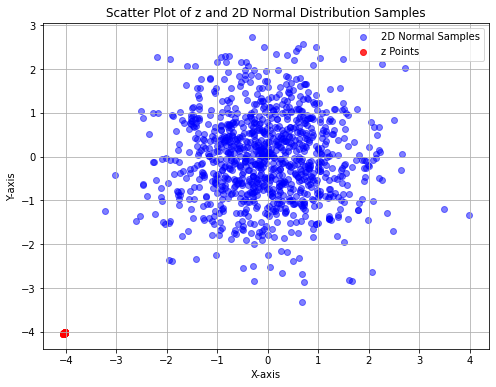

In [1526]:
model_2d.eval()
# print("train_data[:3]"); print(train_data[:3])
z,_ = model_2d(torch.tensor(test_data, dtype=torch.float))
plot_z_and_2d_normal(z.detach().numpy())

# lld = get_weight_determinants(model_2d)
# dja = prod_model_activations_jacobians(model_2d)
# print("lld is:"); print(lld)
# print("dja is:"); print(dja)
# nll_loss(z=z, det_jacob_act=dja, linear_layers_det=lld)

In [1527]:
# z,_ = model_2d_no_linear(torch.tensor(test_data, dtype=torch.float))
# plot_z_and_2d_normal(z.detach().numpy())
# lld = get_weight_determinants(model_2d_no_linear)
# dja = prod_model_activations_jacobians(model_2d_no_linear)
# print("lld is:"); print(lld)
# print("dja is:"); print(dja)
# nll_loss(z=z, det_jacob_act=dja, linear_layers_det=lld)

In [1528]:
# train the model with linear
train_losses, val_losses, model_param_epoch = train_and_evaluate(
    model=model_2d, 
    train_loader=train_loader,val_loader=val_loader,
    lr=0.001,#0.002, 
    num_epochs=10, 
    print_after=1,
    scheduler_type="manual",
    # max_grad_norm=True,
    # grad_norm_type=2,
    alpha_ortho=1000, # do i need to keep it 1000?
    track_coefficients=False, # let's not track coeffs, i need to fix it
    manual_lr_schedule=([10],[0.0008]),
    tv2_regulation=0
) 
# note for me: I am only priniting NLL loss as training loss. 

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

 train loss margin: 10.561182975769043
 total loss margin: 11.174562454223633
 train+alpha*orth loss: 11.174562454223633
orth loss is: 0.0006133797578513622
alpha: 1000 X orth loss is: 0.6133797764778137


Training Progress:  10%|█         | 1/10 [00:11<01:39, 11.05s/it]

Epoch 1/10, Training-full Loss: 521.0710483463832, Training-NLL Loss: 15.039769447871617, Validation Loss: 11.181425327950336, LR: 0.001
 train loss margin: 7.253981113433838
 total loss margin: 7.393730640411377
 train+alpha*orth loss: 7.393730640411377
orth loss is: 0.0001397494343109429
alpha: 1000 X orth loss is: 0.1397494375705719


Training Progress:  20%|██        | 2/10 [00:21<01:24, 10.60s/it]

Epoch 2/10, Training-full Loss: 9.461161570412772, Training-NLL Loss: 9.13405354145595, Validation Loss: 7.066387328695743, LR: 0.001
 train loss margin: 6.283578872680664
 total loss margin: 6.946284294128418
 train+alpha*orth loss: 6.946284294128418
orth loss is: 0.0006627053953707218
alpha: 1000 X orth loss is: 0.6627054214477539


Training Progress:  30%|███       | 3/10 [00:31<01:13, 10.47s/it]

Epoch 3/10, Training-full Loss: 6.023627819333758, Training-NLL Loss: 5.625707811900548, Validation Loss: 4.224374364031122, LR: 0.001
 train loss margin: 2.105803966522217
 total loss margin: 2.4191739559173584
 train+alpha*orth loss: 2.4191739559173584
orth loss is: 0.00031336990650743246
alpha: 1000 X orth loss is: 0.31336989998817444


Training Progress:  40%|████      | 4/10 [00:42<01:02, 10.43s/it]

Epoch 4/10, Training-full Loss: 3.691759974207197, Training-NLL Loss: 3.3730519673483714, Validation Loss: 2.5214487333247004, LR: 0.001
 train loss margin: 1.8545846939086914
 total loss margin: 2.0916690826416016
 train+alpha*orth loss: 2.0916690826416016
orth loss is: 0.00023708441585768014
alpha: 1000 X orth loss is: 0.23708441853523254


Training Progress:  50%|█████     | 5/10 [00:52<00:52, 10.44s/it]

Epoch 5/10, Training-full Loss: 2.2747755432128907, Training-NLL Loss: 2.0382023587226867, Validation Loss: 1.6098922919085685, LR: 0.001
 train loss margin: 1.4083075523376465
 total loss margin: 1.7778408527374268
 train+alpha*orth loss: 1.7778408527374268
orth loss is: 0.00036953328526578844
alpha: 1000 X orth loss is: 0.3695332705974579


Training Progress:  60%|██████    | 6/10 [01:03<00:42, 10.72s/it]

Epoch 6/10, Training-full Loss: 1.7006057660239084, Training-NLL Loss: 1.385446911232812, Validation Loss: 1.1736931499648602, LR: 0.001
 train loss margin: 0.537739634513855
 total loss margin: 0.8365631699562073
 train+alpha*orth loss: 0.8365631699562073
orth loss is: 0.0002988235210068524
alpha: 1000 X orth loss is: 0.2988235354423523


Training Progress:  70%|███████   | 7/10 [01:14<00:31, 10.61s/it]

Epoch 7/10, Training-full Loss: 1.4315712193080357, Training-NLL Loss: 1.1133258011681693, Validation Loss: 1.034643011841368, LR: 0.001
 train loss margin: 0.7939836978912354
 total loss margin: 1.2091450691223145
 train+alpha*orth loss: 1.2091450691223145
orth loss is: 0.00041516139754094183
alpha: 1000 X orth loss is: 0.4151614010334015


Training Progress:  80%|████████  | 8/10 [01:23<00:20, 10.35s/it]

Epoch 8/10, Training-full Loss: 1.3512095012664795, Training-NLL Loss: 1.0190604954447064, Validation Loss: 0.9952147396955084, LR: 0.001
 train loss margin: 1.4085298776626587
 total loss margin: 1.9643011093139648
 train+alpha*orth loss: 1.9643011093139648
orth loss is: 0.0005557711701840162
alpha: 1000 X orth loss is: 0.5557711720466614


Training Progress:  90%|█████████ | 9/10 [01:34<00:10, 10.28s/it]

Epoch 9/10, Training-full Loss: 1.3739605689048766, Training-NLL Loss: 0.9960199798856463, Validation Loss: 0.9842223477490405, LR: 0.001
 train loss margin: 0.8864949941635132
 total loss margin: 1.1879621744155884
 train+alpha*orth loss: 1.1879621744155884
orth loss is: 0.00030146719655022025
alpha: 1000 X orth loss is: 0.3014672100543976


Training Progress: 100%|██████████| 10/10 [01:43<00:00, 10.39s/it]

Epoch 10/10, Training-full Loss: 1.2971147473880222, Training-NLL Loss: 0.9880629502705165, Validation Loss: 0.9828000122562368, LR: 0.001
Training complete


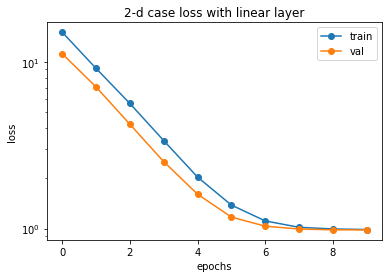

In [1533]:
plot_loss_curves(train_loss=train_losses, val_loss=val_losses,
                title="2-d case loss with linear layer", log_scale=True)

In [1530]:
# train the model with no linear
# train_losses2, val_losses2, model_param_epoch2 = train_and_evaluate(
#     model=model_2d_no_linear, 
#     train_loader=train_loader,val_loader=val_loader,
#     lr=0.001,#0.002, 
#     num_epochs=5, 
#     print_after=1,
#     scheduler_type="manual",
#     max_grad_norm=None,
#     # grad_norm_type=1,
#     track_coefficients=False, # let's not track coeffs, i need to fix it
#     manual_lr_schedule=([5],[0.0005]),
#     tv2_regulation=0
# ) 

In [1531]:
# plot_loss_curves(train_loss=train_losses2, val_loss=val_losses2,
#                 title="2-d case loss- no linear", log_scale=True)

In [1534]:
def plot_with_annotations(x, y, title="Plot with (x, y) Annotations", xlabel="X-axis", ylabel="Y-axis"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, "-o")  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    for x_val, y_val in zip(x, y):
        plt.annotate(
            f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
            (x_val, y_val),  # The point to annotate
            textcoords="offset points",  # Offset the text slightly
            xytext=(5, 5),  # Offset (5, 5) pixels
            fontsize=8,  # Font size of the annotation
            color="red"  # Optional: text color
        )
        plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)  # Optional: Add a grid

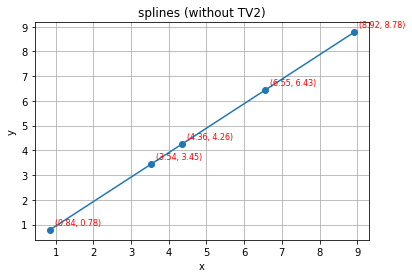

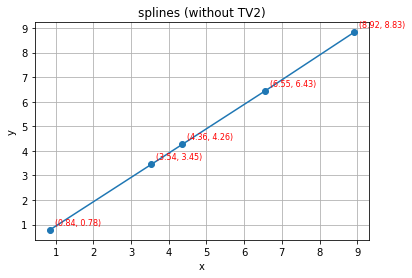

In [1535]:
x,y=model_2d.activations[0].nodal_val_loc_tensor.detach().numpy(),\
model_2d.activations[0].slope_constrained_coefficients_vect.detach().numpy()

# Add labels, title, and grid
plot_with_annotations(x[0], y[:5],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()
plot_with_annotations(x[0], y[5:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

In [ ]:
# x,y=model_2d_no_linear.activations[0].nodal_val_loc_tensor.detach().numpy(),\
# model_2d_no_linear.activations[0].slope_constrained_coefficients_vect.detach().numpy()

# # Add labels, title, and grid
# plot_with_annotations(x[0], y[:5],
#                     title="splines (without TV2)", xlabel="x", ylabel="y")
# plt.show()
# plot_with_annotations(x[0], y[5:],
#                     title="splines (without TV2)", xlabel="x", ylabel="y")
# plt.show()

In [1536]:
model = SplineNN(input_dim=2, hidden_dim=[], output_dim=2,
                    spline_activation_class=LinearSplineSlopeConstrained,
                    spline_kwargs=spline_params)

# model2 = ActivationOnlyNN(depth=1,
#                     spline_activation_class=LinearSplineSlopeConstrained,
#                     spline_kwargs=spline_params)


initial nodal_val_locs: tensor([[-0.3593,  1.9751,  5.1465,  6.5533,  9.8263],
        [-0.3593,  1.9751,  5.1465,  6.5533,  9.8263]])
initial fn values: Parameter containing:
tensor([0.0000, 1.9751, 5.1465, 6.5533, 9.8263, 0.0000, 1.9751, 5.1465, 6.5533,
        9.8263], requires_grad=True)


In [1537]:
def plot_multiple_z_with_normal(models_params, test_data, model, 
                        num_samples=1000, mean=(0, 0), 
                        cov=[[1, 0], [0, 1]], figsize=(12, 12)):
    """
    Plots multiple 2D scatter plots of z and 2D normal distribution samples in a grid with a common legend.

    Args:
    - models_params (list): List of model parameters for each epoch.
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 2D normal distribution.
    - mean (tuple): Mean of the 2D normal distribution.
    - cov (list[list]]): Covariance matrix of the 2D normal distribution.
    - figsize (tuple): Size of the overall figure.

    Returns:
    None
    """
    num_epochs = len(models_params)
    num_rows = int(np.ceil(np.sqrt(num_epochs)))
    num_cols = int(np.ceil(num_epochs / num_rows))
    
    # Prepare the normal distribution samples
    normal_samples = np.random.multivariate_normal(mean, cov, num_samples)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for i, ax in enumerate(axes):
        if i < num_epochs:
            # Load model weights for the current epoch
            print(f"model params are for epoch {i}:"); print(models_params[i])
            load_weights_into_model(model, models_params[i])
            
            # Encode the test data
            with torch.no_grad():
                encoded_test2, _ = model(test_tensor)
            
            # Plot on the subplot
            ax.scatter(normal_samples[:, 0], normal_samples[:, 1], color='blue', alpha=0.3, label="Normal Samples")
            ax.scatter(encoded_test2[:, 0], encoded_test2[:, 1], color='red', alpha=0.3, label="Encoded z")
            ax.set_title(f"Epoch {i}")
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Y-axis")
            ax.grid(True)
        else:
            # Hide unused subplots
            ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.6, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


model params are for epoch 0:
{'layers.0.weight': tensor([[-0.7083,  0.7060],
        [ 0.7062,  0.7082]]), 'activations.0.coefficients_vect': tensor([0.8252, 0.8252, 0.8252, 0.8252, 0.8252, 0.8252, 0.8252, 0.8252, 0.8252,
        8.4937])}
Weights successfully loaded into the model.
model params are for epoch 1:
{'layers.0.weight': tensor([[-0.7082,  0.7061],
        [ 0.7058,  0.7082]]), 'activations.0.coefficients_vect': tensor([1.5521, 1.5521, 1.5521, 1.5521, 1.5521, 1.5521, 1.5521, 1.5521, 1.5521,
        9.2206])}
Weights successfully loaded into the model.
model params are for epoch 2:
{'layers.0.weight': tensor([[-0.7081,  0.7059],
        [ 0.7057,  0.7082]]), 'activations.0.coefficients_vect': tensor([2.2181, 2.2181, 2.2181, 2.2181, 2.2181, 2.2181, 2.2181, 2.2181, 2.2181,
        9.8866])}
Weights successfully loaded into the model.
model params are for epoch 3:
{'layers.0.weight': tensor([[-0.7083,  0.7058],
        [ 0.7059,  0.7083]]), 'activations.0.coefficients_vect': te

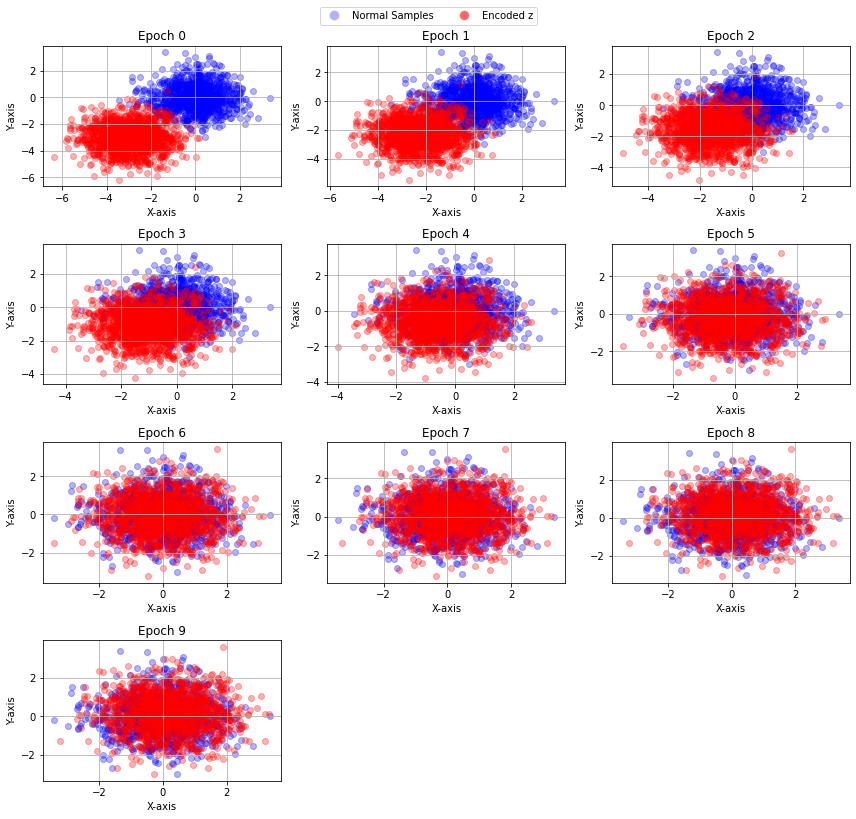

In [1538]:
### evolution of code space with epochs
test_tensor=torch.tensor(test_data, dtype=torch.float)

plot_multiple_z_with_normal(model_param_epoch, test_data, model)

In [ ]:
### evolution of code space with epochs
# test_tensor=torch.tensor(test_data, dtype=torch.float)

# plot_multiple_z_with_normal(model_param_epoch2, test_data, model2)

In [1762]:
# model_2d_no_linear.activations[0].slope_constrained_coefficients_vect

tensor([-7.3298, -4.9098,  0.5199,  2.7588,  4.2947, -7.3298, -4.9098,  0.5199,
         2.7588,  4.2943], grad_fn=<ViewBackward0>)

# ignore everything below

In [1763]:
train_losses_3, val_losses_3, model_param_epoch_3 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.0005, 
    num_epochs=5, 
    print_after=1,
    scheduler_type="ReduceLROnPlateau",
    max_grad_norm=True,
    track_coefficients=False # let's not track coeffs, i need to fix it
) 

Training Progress:  20%|██        | 1/5 [00:10<00:43, 10.91s/it]

Epoch 1/5, Training-full Loss: 3.1175364174161637, Training-NLL Loss: 2.079904412814549, Validation Loss: 2.162172257900238, LR: 0.0005


Training Progress:  40%|████      | 2/5 [00:21<00:32, 10.92s/it]

Epoch 2/5, Training-full Loss: 5.096279579162598, Training-NLL Loss: 2.709773570878165, Validation Loss: 3.718308190081982, LR: 0.0005


Training Progress:  60%|██████    | 3/5 [00:33<00:22, 11.27s/it]

Epoch 3/5, Training-full Loss: 9.896472114018032, Training-NLL Loss: 7.09157280921936, Validation Loss: 13.55521713926437, LR: 0.0005


Training Progress:  80%|████████  | 4/5 [00:47<00:12, 12.36s/it]

Epoch 4/5, Training-full Loss: 23.14091345214844, Training-NLL Loss: 20.312489377702985, Validation Loss: 23.235021591186523, LR: 5e-05


Training Progress: 100%|██████████| 5/5 [00:58<00:00, 11.77s/it]

Epoch 5/5, Training-full Loss: 26.060513166155133, Training-NLL Loss: 23.232086805071148, Validation Loss: 23.235227584838867, LR: 5e-05
Training complete


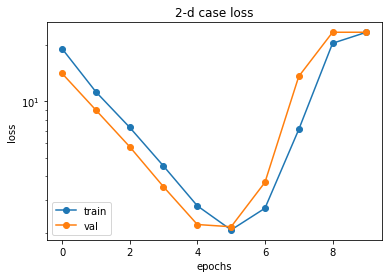

In [1764]:
plot_loss_curves(train_loss=train_losses+train_losses_3, val_loss=val_losses+val_losses_3,
                title="2-d case loss", log_scale=True)

In [1765]:
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

encoded_test

tensor([[0.0001, 0.0001],
        [0.0001, 0.0001],
        [0.0001, 0.0001],
        ...,
        [0.0001, 0.0001],
        [0.0001, 0.0001],
        [0.0001, 0.0001]])

test_data original space:


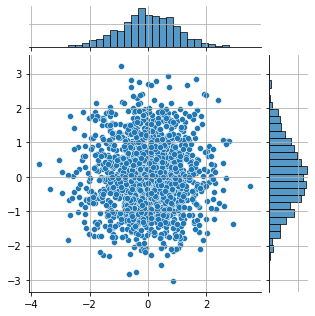

test data in encoded space


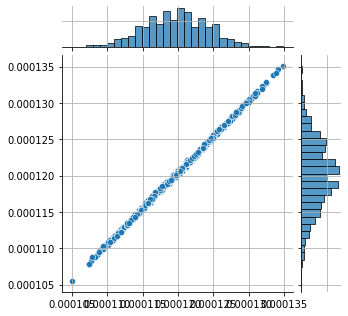

In [1766]:
# now we can try to plot the code space 
print("test_data original space:") 
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

I did the early stopping and it did work! This is the first time I have seen early stopping in action! (atleast in some of the previous experiments I did).

In [1767]:
# train the model for a few more epochs
train_losses_2, val_losses_2, model_param_epoch_2 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.0001, 
    num_epochs=10, 
    print_after=1, 
    scheduler_type='ReduceLROnPlateau',
    track_coefficients=False # let's not track coeffs, i need to fix it
) 


Training Progress:   0%|          | 0/10 [00:09<?, ?it/s]


KeyboardInterrupt: 

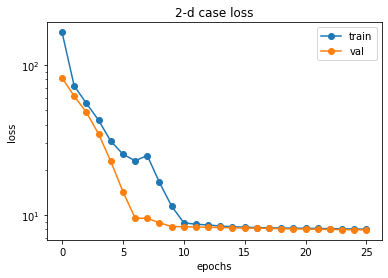

test_data original space:


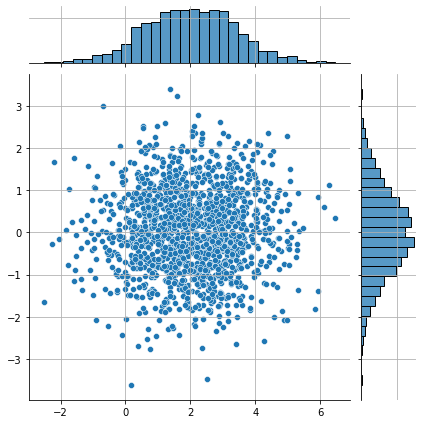

test data in encoded space


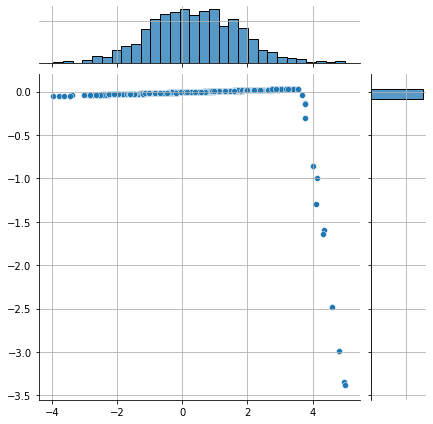

In [73]:
# # combine previous loss curves with the current ones
plot_loss_curves(train_loss=train_losses+train_losses_3+train_losses_2, 
                 val_loss=val_losses+val_losses_3+val_losses_2,
                title="2-d case loss", log_scale=True)

# once again test the model
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

# now we can try to plot the code space 
print("test_data original space:")
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

Training Progress:   7%|▋         | 1/15 [00:16<03:47, 16.27s/it]

Epoch 1/15, Training Loss: 8.012646366664342, Validation Loss: 7.925940521219943, LR: 0.0001


Training Progress:  13%|█▎        | 2/15 [00:30<03:15, 15.06s/it]

Epoch 2/15, Training Loss: 7.994174924033029, Validation Loss: 7.906733933915484, LR: 0.0001


Training Progress:  20%|██        | 3/15 [00:44<02:56, 14.68s/it]

Epoch 3/15, Training Loss: 7.975492274693081, Validation Loss: 7.8909137806993845, LR: 0.0001


Training Progress:  27%|██▋       | 4/15 [00:58<02:39, 14.49s/it]

Epoch 4/15, Training Loss: 7.958019573756626, Validation Loss: 7.894885955972875, LR: 0.0001


Training Progress:  33%|███▎      | 5/15 [01:13<02:24, 14.45s/it]

Epoch 5/15, Training Loss: 7.9430727135794506, Validation Loss: 7.882981635154562, LR: 0.0001


Training Progress:  40%|████      | 6/15 [01:27<02:10, 14.52s/it]

Epoch 6/15, Training Loss: 7.931366128104074, Validation Loss: 7.878137771119463, LR: 0.0001


Training Progress:  47%|████▋     | 7/15 [01:42<01:55, 14.43s/it]

Epoch 7/15, Training Loss: 7.9186631780351915, Validation Loss: 7.869190464628503, LR: 0.0001


Training Progress:  53%|█████▎    | 8/15 [01:56<01:40, 14.41s/it]

Epoch 8/15, Training Loss: 7.906947630746024, Validation Loss: 7.857749472273157, LR: 0.0001


Training Progress:  60%|██████    | 9/15 [02:12<01:29, 14.93s/it]

Epoch 9/15, Training Loss: 7.897096154349191, Validation Loss: 7.858920376351539, LR: 0.0001


Training Progress:  67%|██████▋   | 10/15 [02:27<01:14, 14.92s/it]

Epoch 10/15, Training Loss: 7.888594292776925, Validation Loss: 7.856236196578817, LR: 0.0001


Training Progress:  73%|███████▎  | 11/15 [02:42<00:59, 14.95s/it]

Epoch 11/15, Training Loss: 7.881722363608224, Validation Loss: 7.844855364332807, LR: 0.0001


Training Progress:  80%|████████  | 12/15 [02:57<00:44, 14.98s/it]

Epoch 12/15, Training Loss: 7.872998182024275, Validation Loss: 7.846547187642848, LR: 0.0001


Training Progress:  87%|████████▋ | 13/15 [03:12<00:30, 15.03s/it]

Epoch 13/15, Training Loss: 7.869466773986816, Validation Loss: 7.840332804842198, LR: 0.0001


Training Progress:  93%|█████████▎| 14/15 [03:27<00:14, 14.98s/it]

Epoch 14/15, Training Loss: 7.862215695517404, Validation Loss: 7.832003157189551, LR: 0.0001


Training Progress: 100%|██████████| 15/15 [03:42<00:00, 14.84s/it]

Epoch 15/15, Training Loss: 7.857204748426165, Validation Loss: 7.820557802281481, LR: 0.0001
Training complete


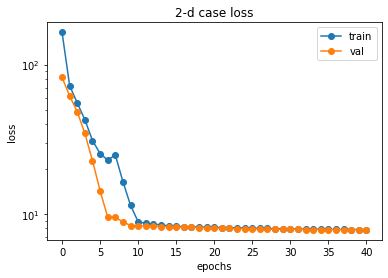

test_data original space:


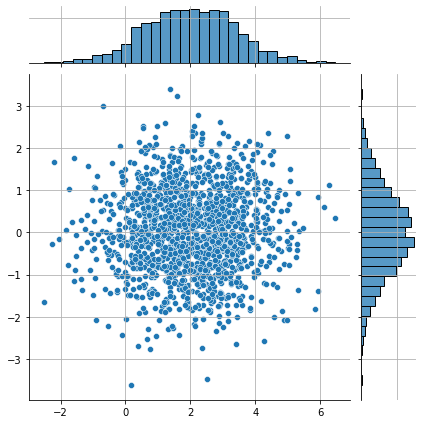

test data in encoded space


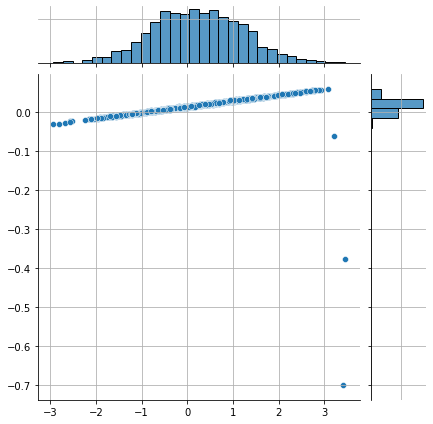

In [74]:
# # combine previous loss curves with the current ones
# train the model for a few more epochs
train_losses_4, val_losses_4, model_param_epoch_4 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.0001, 
    num_epochs=15, 
    print_after=1, 
    scheduler_type='ReduceLROnPlateau',
    track_coefficients=False # let's not track coeffs, i need to fix it
) 

plot_loss_curves(train_loss=train_losses+train_losses_3+train_losses_2+train_losses_4, 
                 val_loss=val_losses+val_losses_3+val_losses_2+val_losses_4,
                title="2-d case loss", log_scale=True)

# once again test the model
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

# now we can try to plot the code space 
print("test_data original space:")
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

In [75]:
# # combine previous loss curves with the current ones
# train the model for a few more epochs
train_losses_5, val_losses_5, model_param_epoch_5 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.0001, 
    num_epochs=15, 
    print_after=1, 
    scheduler_type='ReduceLROnPlateau',
    track_coefficients=False # let's not track coeffs, i need to fix it
) 

plot_loss_curves(train_loss=train_losses+train_losses_3+train_losses_2+train_losses_4+ train_losses_5, 
                 val_loss=val_losses+val_losses_3+val_losses_2+val_losses_4+ val_losses_5,
                title="2-d case loss", log_scale=True)

# once again test the model
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

# now we can try to plot the code space 
print("test_data original space:")
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

Training Progress:   7%|▋         | 1/15 [00:15<03:38, 15.60s/it]

Epoch 1/15, Training Loss: 7.8505892699105395, Validation Loss: 7.832182006633028, LR: 0.0001


Training Progress:  13%|█▎        | 2/15 [00:32<03:32, 16.34s/it]

Epoch 2/15, Training Loss: 7.850703138078962, Validation Loss: 7.833061005206818, LR: 0.0001


Training Progress:  20%|██        | 3/15 [00:46<03:05, 15.48s/it]

Epoch 3/15, Training Loss: 7.850885607038226, Validation Loss: 7.838488241459461, LR: 0.0001


Training Progress:  27%|██▋       | 4/15 [01:02<02:49, 15.40s/it]

Epoch 4/15, Training Loss: 7.852790863037109, Validation Loss: 7.842767657117641, LR: 1e-05


: 

### Task for now: investigate the shape of x while working with the activation function. I think there is something definitely wrong here!

Let's investigate the activation function first

In [48]:
# spline_params = {
#     "mode": "fc",
#     "num_activations": 1,
#     "size": 5,
#     "range_": 10,
#     "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
#     "init": "relu",
#     "smin": 0.001,
#     "smax": 1 / 0.001,
#     "slope_constrained": True,
# }
# act_check_1=LinearSplineSlopeConstrained(**spline_params)


In [49]:
spline_params2 = {
    "mode": "fc",
    "num_activations": 2,
    "size": 5,
    "range_": 10,
    "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
    "init": "relu",
    "smin": 0.001,
    "smax": 1 / 0.001,
    "slope_constrained": True,
}
act_check_2=LinearSplineSlopeConstrained(**spline_params2)

initial nodal_val_locs: tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000],
        [-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
initial fn values: Parameter containing:
tensor([0.0000, 0.0000, 2.7000, 4.5000, 6.5000, 0.0000, 0.0000, 2.7000, 4.5000,
        6.5000], requires_grad=True)


d:\Desktop\lipschitz_network_third_sem\Lipschitz_DSNN\activations\linearspline_slope_constraint.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


In [50]:
act_test_tensor2=torch.tensor([[1.,100.],[100.,1.],[100.,1.],[3.,100.]], 
                            dtype=torch.float32)
print(act_test_tensor2)

tensor([[  1., 100.],
        [100.,   1.],
        [100.,   1.],
        [  3., 100.]])


In [51]:
act_check_2(act_test_tensor2) # this did not throw error. why? # this makes sense!

tensor([[  2.0154, 100.0005],
        [100.0005,   2.0154],
        [100.0005,   2.0154],
        [  3.0005, 100.0005]], grad_fn=<ViewBackward0>)

In [52]:
act_check_2.grad_x_temp

tensor([[0.4030, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.4030, 0.4030, 1.0000]], grad_fn=<LinearSpline_FuncBackward>)

In [53]:
act_test_tensor = torch.tensor([[3.],[100.]], dtype=torch.float32)
act_check_1(act_test_tensor)
act_check_1.grad_x_temp

NameError: name 'act_check_1' is not defined

In [85]:
# act_check_1(act_test_tensor)# throws error